In [ ]:
%pip install mmh3

In [ ]:
%pip install bitarray

In [3]:
#Reading dataset

import pandas as pd

data = pd.read_csv('data.csv')
data = data.dropna()
pos_keys = data['url'][0:1000000]
neg_keys = data['url'][1000000:]

In [4]:
#Implementing bloom filter

import math
import mmh3
from bitarray import bitarray
 
 
class Bloom(object):

    def __init__(self, items_count, fp_prob):
  
        self.fp_prob = fp_prob 
        self.size = self.get_size(items_count, fp_prob)
        self.hash_count = self.get_hash_count(self.size, items_count)
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0)
 
    def add(self, item):

        digests = []
        for i in range(self.hash_count):
            digest = mmh3.hash(item, i) % self.size
            digests.append(digest)
            self.bit_array[digest] = True
 
    def check(self, item):
        for i in range(self.hash_count):
            digest = mmh3.hash(item, i) % self.size
            if self.bit_array[digest] == False:
                return False
        return True
 
    @classmethod
    def get_size(self, n, p):
        m = -(n * math.log(p))/(math.log(2)**2)
        return int(m)
 
    @classmethod
    def get_hash_count(self, m, n):
        k = (m/n) * math.log(2)
        return int(k)


In [5]:
# Building a bloom filter of pos_keys

import time

f = Bloom(pos_keys.shape[0],0.1)
start = time.time()
for i in pos_keys:
  f.add(i)
print(f'Time to build filter: {time.time() - start}')

Time to build filter: 1.8691513538360596


In [6]:
#Statistics of bloom filter

print("Size of bit array:{}".format(f.size))
print("False positive Probability:{}".format(f.fp_prob))
print("Number of hash functions:{}".format(f.hash_count))

Size of bit array:4792529
False positive Probability:0.1
Number of hash functions:3


In [7]:
#Query set is first 5000000 elements of pos_keys and neg_keys
#Checking fp and fn rate of bloom filter on the query set

counter = 0
fn = 0
fp = 0

for i in pos_keys:
  if counter != 500000:
    if f.check(i) == False:
      fn += 1 
    counter += 1
  else:
    break

counter = 0

for i in neg_keys:
  if counter != 500000:
    if f.check(i) == True:
      fp += 1 
    counter += 1
  else:
    break

print('False positive rate is :{}'.format(fp/10000))
print('False negative rate is :{}'.format(fn/10000))

False positive rate is :5.7812
False negative rate is :0.0


In [8]:
#Implementing deletable bloom filter

import math
import mmh3
from bitarray import bitarray


class DeletableBloomFilter():

  def __init__(self,m,r,k):

    self.m = m
    self.r = r
    self.k = k

    self.bit_array = bitarray(self.m + self.r)
    self.bit_array.setall(0)

  def add(self, item):

    for i in range(self.k):
      digest = mmh3.hash(item, i) % (self.m)
      if self.bit_array[digest] == True:
        r_bit = self.m - 1 + math.ceil((digest+1) / (math.ceil(self.m/self.r)))
        self.bit_array[r_bit] = True
      else :
        self.bit_array[digest] = True

  def check(self, item):

    for i in range(self.k):
      digest = mmh3.hash(item, i) % (self.m)
      if self.bit_array[digest] == False:
        return False

    return True

  def delete(self,item, return_index = False):
    for i in range(self.k):
      digest = mmh3.hash(item, i) % (self.m)
      r_bit = self.m - 1 + math.ceil((digest+1) / (math.ceil(self.m/self.r)))

      returned_val = None
      if self.bit_array[digest] == True and self.bit_array[r_bit] == False:
        self.bit_array[digest] = False
        returned_val = digest

      if (return_index):  #return index of deleted 
        return returned_val


In [10]:
# Building a deletable filter of pos_keys

k = f.hash_count
m = f.size
r = math.ceil(0.7 * m)
df = DeletableBloomFilter(m,r,k)

start = time.time()
for i in pos_keys:
  df.add(i)
print(f'Time to build deletable filter: {time.time() - start}')

Time to build deletable filter: 2.3737740516662598


In [11]:
#Statistics of deletable filter

print("Size of bit array:{}".format(len(df.bit_array)))
print("Number of hash functions:{}".format(df.k))

Size of bit array:8147300
Number of hash functions:3


In [12]:
#Query set is first 5000000 elements of pos_keys and neg_keys
#Checking fp and fn rate of deletable filter on the query set

counter = 0
fn = 0
fp = 0

for i in pos_keys:
  if counter != 500000:
    if df.check(i) == False:
      fn += 1 
    counter += 1
  else:
    break

counter = 0

for i in neg_keys:
  if counter != 500000:
    if df.check(i) == True:
      fp += 1 
    counter += 1
  else:
    break

print('False positive rate is :{}'.format(fp/10000))
print('False negative rate is :{}'.format(fn/10000))

False positive rate is :5.7812
False negative rate is :0.0


#Experiment 1:

Checking the performance of Bloom filter vs Deletable Filter after series of n = 20000 deletions on the query set


In [13]:
# Bloom filter performance

bfp = fp
bfp_history = [bfp/10000]
deletions = [0]

for i in range(20):
  bfp += 20000
  bfp_history.append(bfp/10000)
  deletions.append(20000 * (i+1))

print(bfp_history)

[5.7812, 7.7812, 9.7812, 11.7812, 13.7812, 15.7812, 17.7812, 19.7812, 21.7812, 23.7812, 25.7812, 27.7812, 29.7812, 31.7812, 33.7812, 35.7812, 37.7812, 39.7812, 41.7812, 43.7812, 45.7812]


In [14]:
# Deletable filter performance

dfp_history = [fp/10000]
deleted_samples = pos_keys[0:0]

for i in range(1,21):
  sample = pos_keys[20000*(i-1):20000*i]
  deleted_samples = deleted_samples.append(sample)

  for i in sample:
    df.delete(i)

  dfp = 0 

  for i in neg_keys[0:500000]:
    if df.check(i) == True:
      dfp += 1 

  for i in deleted_samples:
    if df.check(i) == True:
      dfp += 1 

  dfp_history.append(dfp/10000)

print(dfp_history)

[5.7812, 5.9164, 6.064, 6.2679, 6.4776, 6.6547, 6.8243, 7.0011, 7.1886, 7.3844, 7.6393, 7.889, 8.0866, 8.3193, 8.5192, 8.73, 8.9696, 9.186, 9.4193, 9.6562, 9.8776]


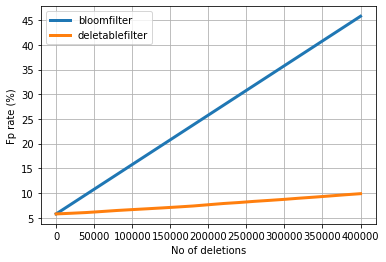

In [15]:
#Visualising performance of both filters after n deletions

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(deletions,bfp_history,'-',linewidth=3,label='bloomfilter')
plt.plot(deletions,dfp_history,'-',linewidth=3,label='deletablefilter')
plt.xlabel('No of deletions')
plt.ylabel('Fp rate (%)')
plt.grid(True)
plt.legend()
plt.savefig('exp1.png')

#Experiment 2:

Checking the performance of Deletable Filter after series of n = 20000 insertions and deletions on the query set

In [16]:
#Building deletable filer of 500000 elements of pos_keys

df2 = DeletableBloomFilter(m//2,r//2,k)

start = time.time()
for i in pos_keys[0:500000]:
  df2.add(i)
print(f'Time to build deletable filter: {time.time() - start}')

Time to build deletable filter: 1.115344524383545


In [17]:
#Checking fp rate on query set of 500000 neg_keys

dfp2 = 0

for i in neg_keys[0:500000]:
  if df2.check(i) == True:
    dfp2 += 1

print('False positive rate is :{}'.format(dfp2/5000))

False positive rate is :10.3766


In [18]:
#Checking fp rate on query set after 20000 insertions and deletions

dfp2_history = [dfp2/5000]
deleted_list = pos_keys[0:0]

for i in range(1,21):
  insert_samples = pos_keys[500000+(20000*(i-1)):500000+(20000*i)]
  sample = pos_keys[20000*(i-1):20000*i]
  deleted_list = deleted_list.append(sample)

  for i in sample:
    df2.delete(i)
  
  for i in insert_samples:
    df2.add(i)

  dfp2 = 0 

  for i in neg_keys[0:500000]:
    if df2.check(i) == True:
      dfp2 += 1 

  for i in deleted_list:
    if df2.check(i) == True:
      dfp2 += 1 


  dfp2_history.append(dfp2/5000)

print(dfp2_history)

[10.3766, 11.141, 12.1392, 13.2342, 14.404, 15.6854, 17.0682, 18.539, 20.2412, 22.078, 24.0912, 26.2264, 28.3498, 30.6646, 33.0432, 35.2346, 37.7652, 40.9368, 43.7934, 46.6864, 49.787]


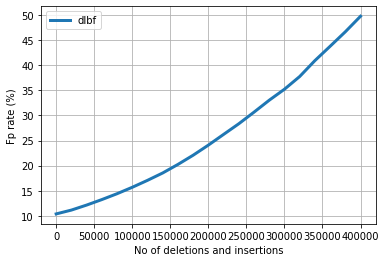

In [19]:
#Visualising performance of dlbf after n insertions and deletions

plt.plot(deletions,dfp2_history,'-',linewidth=3,label='dlbf')
plt.xlabel('No of deletions and insertions')
plt.ylabel('Fp rate (%)')
plt.grid(True)
plt.legend()
plt.savefig('exp2.png')